In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')


from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

tqdm.pandas()

In [7]:
rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [9]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [11]:
summary(train)

data shape: (15289, 18)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
id,int64,0,0.0,15289,0.000000,15288.000000,0.000000,1.000000,2.000000
clonesize,float64,0,0.0,6,10.000000,40.000000,25.000000,25.000000,12.500000
honeybee,float64,0,0.0,7,0.000000,18.430000,0.500000,0.500000,0.250000
bumbles,float64,0,0.0,11,0.000000,0.585000,0.250000,0.250000,0.250000
andrena,float64,0,0.0,16,0.000000,0.750000,0.750000,0.500000,0.630000
osmia,float64,0,0.0,14,0.000000,0.750000,0.500000,0.500000,0.630000
MaxOfUpperTRange,float64,0,0.0,6,69.700000,94.600000,69.700000,69.700000,86.000000
MinOfUpperTRange,float64,0,0.0,5,39.000000,57.200000,42.100000,42.100000,52.000000
AverageOfUpperTRange,float64,0,0.0,5,58.200000,79.000000,58.200000,58.200000,71.900000
MaxOfLowerTRange,float64,0,0.0,6,50.200000,68.200000,50.200000,50.200000,62.000000


💡 Summary of EDA:
There are 16 X variables and 1 target(y) variable, while 1 variable(id) is extra data

No missing values on each columns~!

All variables are float64 type.

In [12]:
num_cols = test.select_dtypes(include=['float64','int64']).columns.tolist()
num_cols.remove('id')

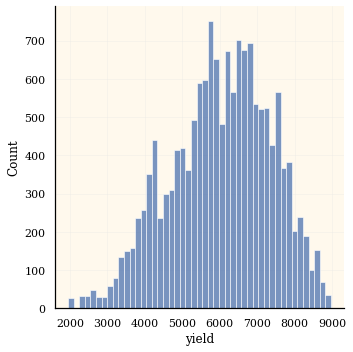

In [14]:
sns.displot(train, x="yield")

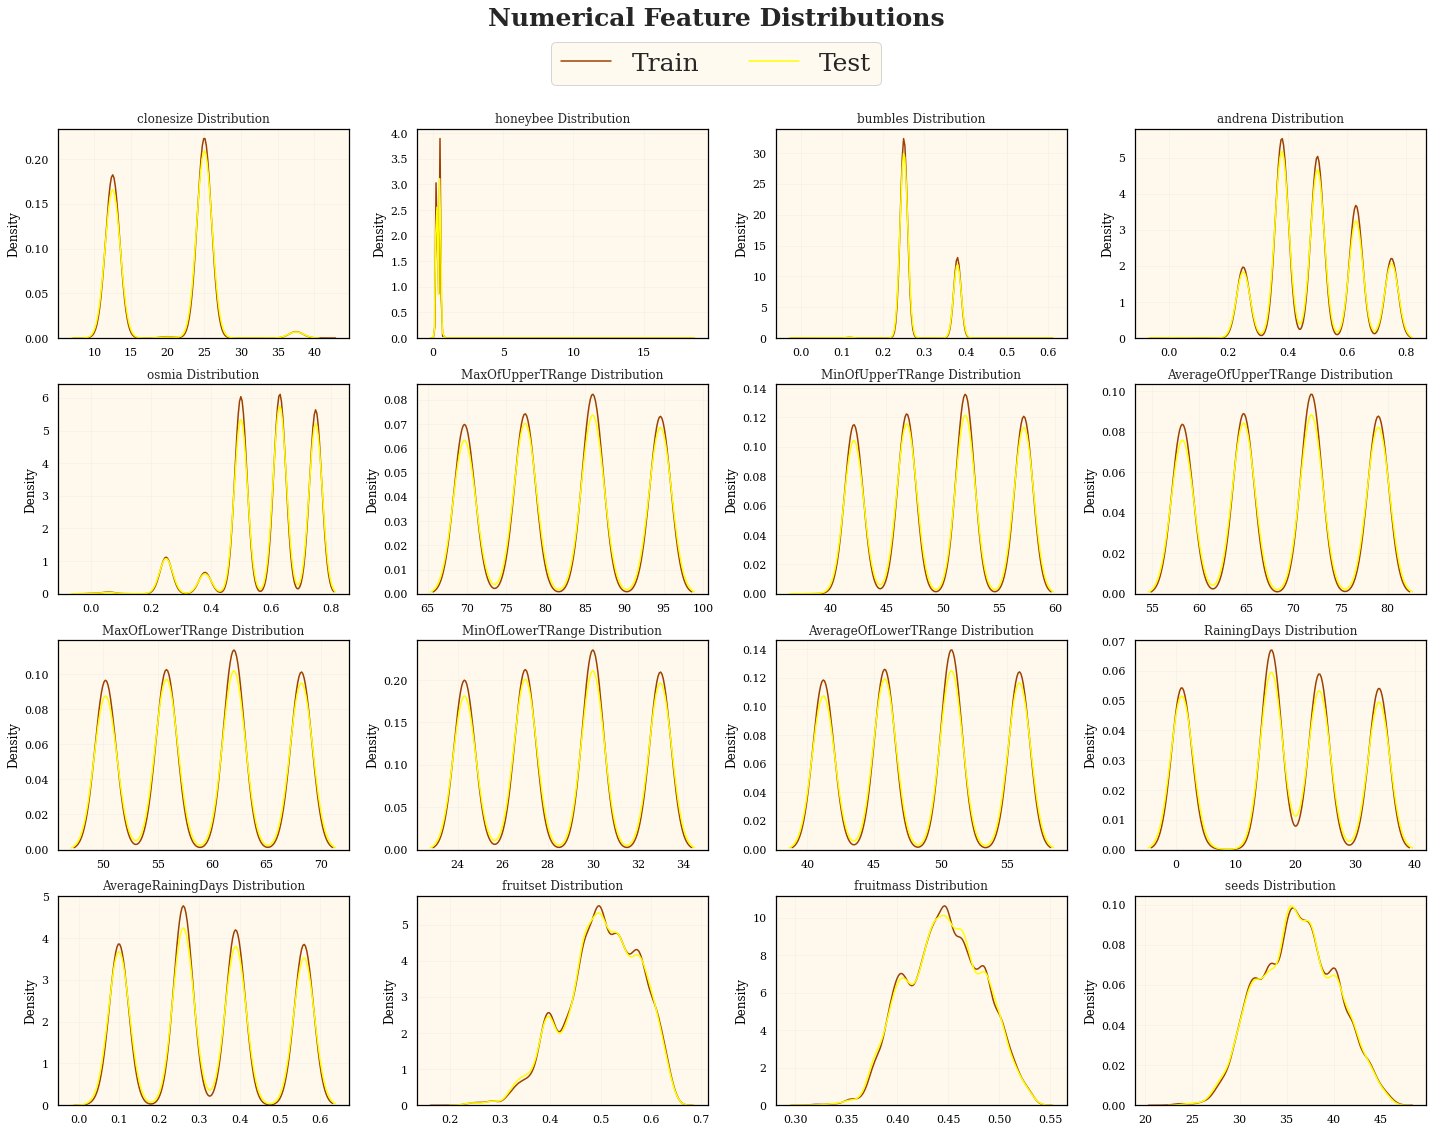

In [15]:
features = num_cols
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train[column], label='Train',
        ax=ax[i], color='#9E3F00'
    )
    
    sns.kdeplot(
        test[column], label='Test',
        ax=ax[i], color='yellow'
    )
    
#     sns.kdeplot(
#         original[column], label='Original',
#         ax=ax[i], color='#20BEFF'
#     )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Numerical Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()

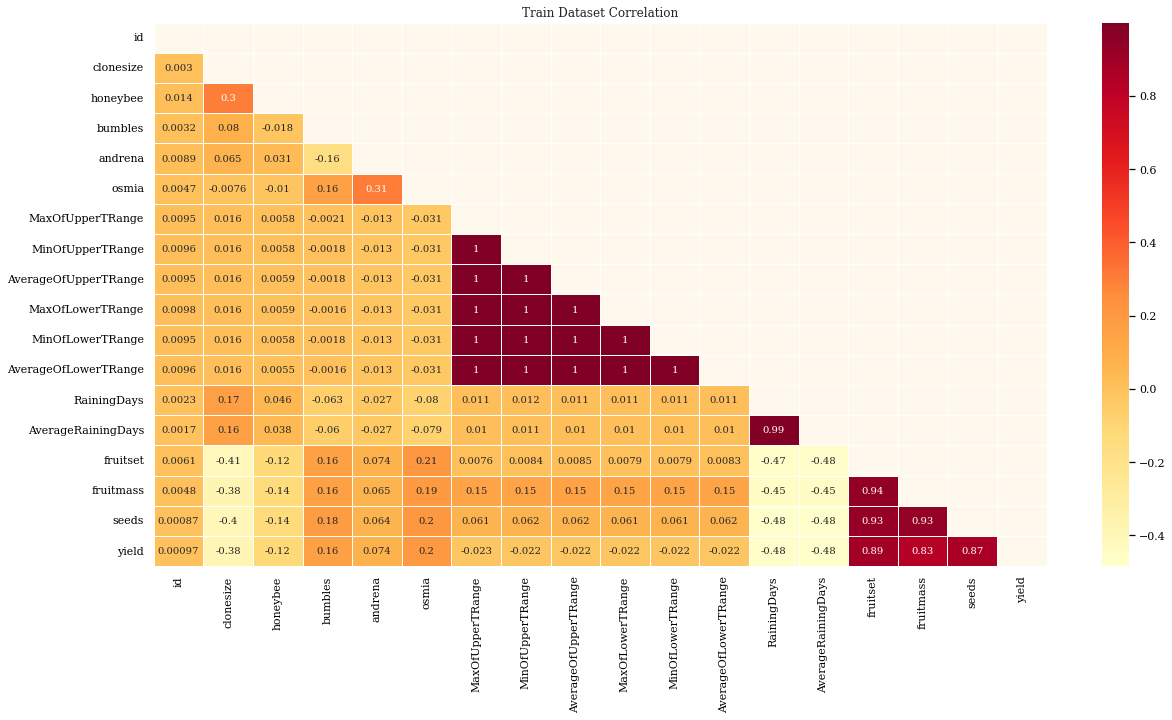

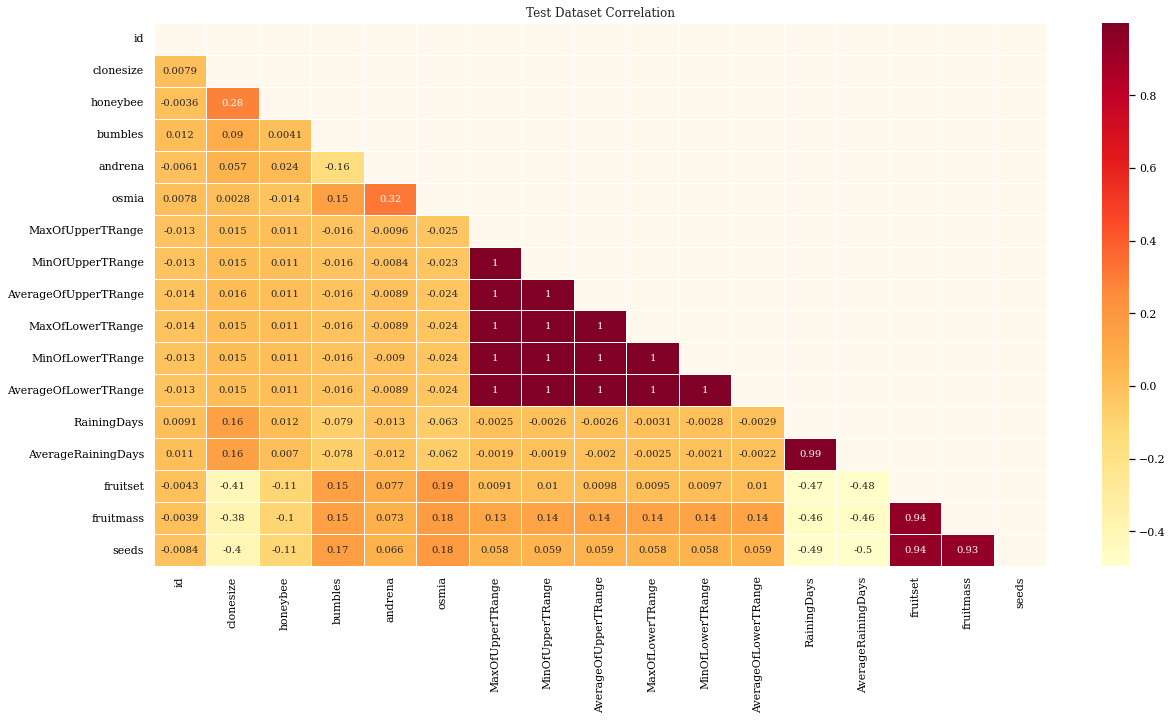

In [16]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# plot_correlation_heatmap(original, 'Original Dataset Correlation')
plot_correlation_heatmap(train, 'Train Dataset Correlation')
plot_correlation_heatmap(test, 'Test Dataset Correlation')

In [17]:
train.drop('id',axis=1, inplace=True)
X = train.drop('yield',axis=1)
Y = train['yield']

In [18]:
test.set_index('id',inplace=True)

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
id,,,,,,,,,,,,,,,,
15289,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.399367,0.408088,31.394569
15290,12.5,0.25,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.488048,0.442866,36.846956
15291,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583379,0.487057,40.037644
15292,25.0,0.50,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.433014,0.422847,33.116091
15293,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.360996,0.388860,29.558019


In [19]:
from sklearn.metrics import mean_absolute_error

cv_scores = list()
importance_xgb = list()
preds = list()

## Running 3 fold CV
for i in range(3):
    print(f'{i} fold cv begin')
    skf = KFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBRegressor(tree_method = 'gpu_hist',
                              objective = 'reg:squarederror',
                              colsample_bytree = 0.8, 
                              gamma = 0.8, 
                              learning_rate = 0.01, 
                              max_depth = 5, 
                              min_child_weight = 10, 
                              n_estimators = 1000, 
                              subsample = 0.8).fit(X_train, Y_train)
        importance_xgb.append(XGB_md.feature_importances_)
        
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test)
        
        # Calculate RMSE
        cv_scores.append(mean_absolute_error(Y_test, XGB_pred_1))
        preds.append(XGB_pred_2)
        print(f'{i} fold cv done')

scores = np.mean(cv_scores)    
print('The average RMSE over 3-folds (run 3 times) is:', scores)

0 fold cv begin
0 fold cv done
0 fold cv done
0 fold cv done
0 fold cv done
0 fold cv done
1 fold cv begin
1 fold cv done
1 fold cv done
1 fold cv done
1 fold cv done
1 fold cv done
2 fold cv begin
2 fold cv done
2 fold cv done
2 fold cv done
2 fold cv done
2 fold cv done
The average RMSE over 3-folds (run 3 times) is: 352.4036112029134


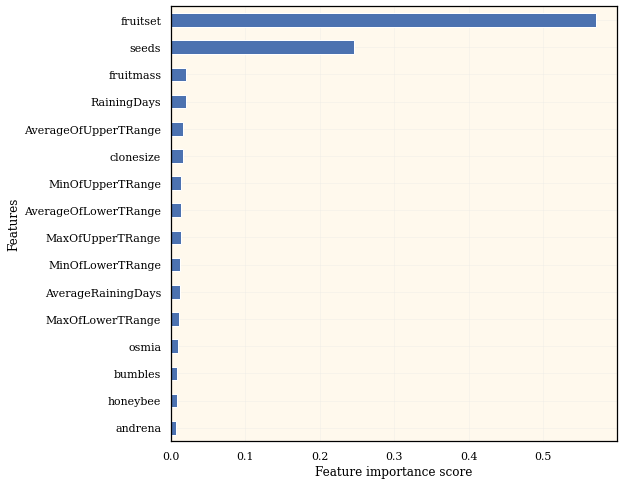

In [20]:
plt.figure(figsize = (8, 8))
pd.DataFrame(importance_xgb, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('Feature importance score')
plt.ylabel('Features')
plt.show(); 